In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import h5py, os, optuna, torch
from scipy.spatial import KDTree
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as torchg
import torch_scatter as torchs

import Graph_Functions as graph
import Merger_Tree_Script as mts

In [2]:
# Walking the merger tree for all boxes in the DREAMS WDM SB4 MW zoom-in suite. SnapNum, SubhaloID, and DescendantID are
# required to construct the merger trees. Add any additional tags for data features you want to use. Documentation can
# be found at: https://www.tng-project.org/data/docs/specifications/#sec2b

boxes = range(30) # For all the boxes, do range(1024)
datalist = []
for box in boxes:
    try:
        data = mts.walk_tree(0,"SnapNum","SubhaloID","DescendantID")
        datalist.append(data)
    except Exception as e:
        print(e)
        print(box)

In [3]:
# Establish path to parameter file

param_path = 'WDM_TNG_MW_SB4_parameters.txt'
params = []
boxes = range(30)
for box in boxes:
    try:
        param = graph.get_params(param_path)[box]
        params.append(param)
    except:
        print(box)

params = np.array(params)
nparams = graph.norm_params(params)
params = nparams[:,0:1] # Change to the column you want to use for parameters

In [4]:
# Create Graph objects with the data features and the parameters

dataset = []
for i in range(len(datalist)):
    dataset.append(graph.create_dataset(datalist[i], params[i]))

In [5]:
# Split the dataset

train_size = 0.8
valid_size = 0.1
test_size  = 0.1
batch_size = 32

train_data, valid_data, test_data = graph.split_dataset(dataset, train_size, valid_size, test_size)
train_loader = graph.DataLoader(train_data, batch_size=batch_size, shuffle=True) 
valid_loader = graph.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = graph.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [6]:
# Define hyperparameters object, GNN object

class Hyperparameters():
    """
    This object acts as a container for the hyperparameters that are used during training.
    This object is also used to name files that are stored during training and testing.
    """
    def __init__(self, lr, wd, nl, hc, rl, ne, name):
        
        self.learning_rate = lr
        self.weight_decay = wd
        self.n_layers = nl
        self.hidden_channels = hc
        self.r_link = rl
        self.n_epochs = ne #set small at first
        self.study_name = name
        self.outmode = 'cosmo'
        self.pred_params = 1
        
    def __repr__(self):
        return f"lr {self.learning_rate:.2e}; wd {self.weight_decay:.2e}; nl {self.n_layers}; hc {self.hidden_channels}; rl {self.r_link:.2e}"
    
    def name_model(self):
        return f"{name}_lr_{self.learning_rate:.2e}_wd_{self.weight_decay:.2e}_nl_{self.n_layers}_hc_{self.hidden_channels}_rl_{self.r_link:.2e}"

class EdgeModel(torch.nn.Module):
    def __init__(self, node_in, node_out, edge_in, edge_out, hid_channels, residuals=True, norm=False):
        super().__init__()

        self.residuals = residuals
        self.norm = norm

        layers = [torch.nn.Linear(node_in*2 + edge_in, hid_channels),
                  torch.nn.ReLU(),
                  torch.nn.Linear(hid_channels, edge_out)]
        
        if self.norm:  
            layers.append(torchg.nn.LayerNorm(edge_out))

        self.edge_mlp = torch.nn.Sequential(*layers)


    def forward(self, src, dest, edge_attr, u, batch):

        out = torch.cat([src, dest, edge_attr], dim=1)
        out = self.edge_mlp(out)
        if self.residuals:
            out = out + edge_attr
        return out

class NodeModel(torch.nn.Module):
    def __init__(self, node_in, node_out, edge_in, edge_out, hid_channels, residuals=True, norm=False):
        super().__init__()

        self.residuals = residuals
        self.norm = norm

        layers = [torch.nn.Linear(node_in + 3*edge_out + 1, hid_channels),
                  torch.nn.ReLU(),
                  torch.nn.Linear(hid_channels, node_out)]
        
        if self.norm:  
            layers.append(torchg.nn.LayerNorm(node_out))

        self.node_mlp = torch.nn.Sequential(*layers)

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = edge_attr

        # Multipooling layer
        out1 = torchs.scatter_add(out, col, dim=0, dim_size=x.size(0))
        out2 = torchs.scatter_max(out, col, dim=0, dim_size=x.size(0))[0]
        out3 = torchs.scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out1, out2, out3, u[batch]], dim=1)

        out = self.node_mlp(out)
        if self.residuals:
            out = out + x
        return out

class GNN(torch.nn.Module):
    def __init__(self, node_features, n_layers, hidden_channels, linkradius, dim_out, only_positions, residuals=True):
        super().__init__()

        self.n_layers = n_layers
        self.link_r = linkradius
        self.dim_out = dim_out
        self.only_positions = only_positions

        # Number of input node features (0 if only_positions is used)
        node_in = node_features
        # Input edge features: |p_i-p_j|, p_i*p_j, p_i*(p_i-p_j)
        edge_in = 3
        node_out = hidden_channels
        edge_out = hidden_channels
        hid_channels = hidden_channels
        
        layers = []

        # Encoder graph block
        inlayer = torchg.nn.MetaLayer(node_model=NodeModel(node_in, node_out, edge_in, edge_out, hid_channels, residuals=False),
                                      edge_model=EdgeModel(node_in, node_out, edge_in, edge_out, hid_channels, residuals=False))

        layers.append(inlayer)

        # Change input node and edge feature sizes
        node_in = node_out
        edge_in = edge_out

        # Hidden graph blocks
        for i in range(n_layers-1):

            lay = torchg.nn.MetaLayer(node_model=NodeModel(node_in, node_out, edge_in, edge_out, hid_channels, residuals=residuals),
                                      edge_model=EdgeModel(node_in, node_out, edge_in, edge_out, hid_channels, residuals=residuals))
            layers.append(lay)

        self.layers = torch.nn.ModuleList(layers)

        # Final aggregation layer
        self.outlayer = torch.nn.Sequential(torch.nn.Linear(3*node_out+1, hid_channels),
                              torch.nn.ReLU(),
                              torch.nn.Linear(hid_channels, hid_channels),
                              torch.nn.ReLU(),
                              torch.nn.Linear(hid_channels, hid_channels),
                              torch.nn.ReLU(),
                              torch.nn.Linear(hid_channels, self.dim_out))

    def forward(self, data):

        h, edge_index, edge_attr, u, batch = data.x, data.edge_index, data.edge_attr, data.u, data.batch

        # Message passing layers
        for layer in self.layers:
            h, edge_attr, _ = layer(h, edge_index, edge_attr, u, data.batch)

        # Multipooling layer
        addpool = torchg.nn.global_add_pool(h, batch)
        meanpool = torchg.nn.global_mean_pool(h, batch)
        maxpool = torchg.nn.global_max_pool(h, batch)
    
        out = torch.cat([addpool,meanpool,maxpool,u], dim=1)

        # Final linear layer
        out = self.outlayer(out)

        return out

In [7]:
# Create GNN

base_name = "gnn_test" # Name that the files will be saved as. Make it different for every unique GNN you train.

name = base_name           
boxes = range(1024)        # Which simulations you include, there are 1024 simulations
prediction = [0]   

# Initial hyperparameters (will be tuned)

rl = 300       # Linking radius
lr = 7e-4      # Learning rate
wd = 2e-8      # Weight decay
nl = 2         # Number of layers
hc = 512       # Hidden channels (power of 2)
n_epochs = 100  # Number of epochs
hparams = Hyperparameters(lr, wd, nl, hc, rl, n_epochs, name)
print(hparams)

## Create GNN based on hyperparameters
model = GNN(node_features=dataset[0].x.shape[1],
            n_layers=hparams.n_layers,
            hidden_channels=hparams.hidden_channels,
            linkradius=hparams.r_link,
            dim_out=len(prediction)*2,
            only_positions=False)

lr 7.00e-04; wd 2.00e-08; nl 2; hc 512; rl 3.00e+02


In [8]:
# Move to gpu/cpu (highly recommend gpu)

if torch.cuda.is_available():
    device = torch.device('cuda') #gpu
else:
    device = torch.device('cpu')
model.to(device)
print(device)

cuda


In [9]:
# Define training functions

def train_model(model, train_loader, valid_loader, hparams):
    """
    This is the main loop for training the GNN. For each epoch, the GNN is given data from the training set to update its parameters and is then tested on the validation set to see if the model has improved.
    If the model has improved, the GNN is saved in a file which can be reloaded later.
    
    Inputs
     - model - the instantiated and untrained GNN
     - train_loader - a pytorch_geometric DataLoader object containing the training dataset
     - valid_loader - a pytorch_geometric DataLoader object containing the validation dataset
     - hparams - a Hyperparameters object containing the hyperparameters to be used in this training session
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams.learning_rate, weight_decay=hparams.weight_decay)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=hparams.learning_rate, max_lr=1.e-3, cycle_momentum=False, step_size_up=500)
    
    train_losses, valid_losses = [], []
    valid_loss_min, err_min = 1000., 1000.
    
    for epoch in range(1, hparams.n_epochs+1):
        train_loss = train(train_loader, model, hparams, optimizer, scheduler)
        valid_loss, err = test(valid_loader, model, hparams)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Save model if it has improved
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), "Models/"+hparams.name_model())
            valid_loss_min = valid_loss
            err_min = err
            print(f"Epoch {epoch:03d} Train loss {train_loss:.2e} Valid loss {valid_loss:.2e} Error: {err:.2e} (B)")
        else:
            print(f"Epoch {epoch:03d} Train loss {train_loss:.2e} Valid loss {valid_loss:.2e} Error: {err:.2e}")
            
    return train_losses, valid_losses

def train(loader, model, hparams, optimizer, scheduler):
    """
    This function loops over all data in the training dataset, calculates the loss, and updates the GNN parameters appropriately.
    
    Inputs
     - loader - a pytorch_geometric DataLoader object containing the training dataset
     - model - the partially trained GNN object
     - hparams - a Hyperparameters object containing the hyperparameters to be used in this training session
     - optimizer - the pytorch optimizer used to update the GNN
     - scheduler - the pytorch scheduler used to vary the training rates / momentum
     
    Returns
     - loss - the average log loss from this epoch
    """
    model.train()

    loss_tot = 0
    
    for data in loader:  # Iterate in batches over the training dataset.

        data.to(device)
        optimizer.zero_grad()  # Clear gradients.
        out = model(data)  # Perform a single forward pass.
        
        y_out, err_out = out[:,:hparams.pred_params], out[:,hparams.pred_params:2*hparams.pred_params]     # Take mean and standard deviation of the output
        
        # Compute loss as sum of two terms for likelihood-free inference
        loss_mse = torch.mean(torch.sum((y_out - data.y)**2., axis=1) , axis=0)
        loss_lfi = torch.mean(torch.sum(((y_out - data.y)**2. - err_out**2.)**2., axis=1) , axis=0)
        loss = torch.log(loss_mse) + torch.log(loss_lfi)

        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        scheduler.step()
        loss_tot += loss.item()

    return loss_tot/len(loader)

def test(loader, model, hparams):
    """
    This function loops over all data in the given (validation or testing) dataset and calculates the loss. 
    The parameters of the model are not updated in this function.
    
    Inputs
     - loader - a pytorch_geometric DataLoader object containing the validation or testing dataset
     - model - the partially trained GNN object
     - hparams - a Hyperparameters object containing the hyperparameters to be used in this training session
     
    Returns
     - loss - the average log loss from this epoch
     - errs - the average absolute error from the GNN predictions
    """
    model.eval()

    trueparams = np.zeros((0,hparams.pred_params))
    outparams = np.zeros((0,hparams.pred_params))
    outerrparams = np.zeros((0,hparams.pred_params))

    errs = []
    loss_tot = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        with torch.no_grad():

            data.to(device)
            out = model(data)  # Perform a single forward pass.

            # If cosmo parameters are predicted, perform likelihood-free inference to predict also the standard deviation
            y_out, err_out = out[:,:hparams.pred_params], out[:,hparams.pred_params:2*hparams.pred_params]     # Take mean and standard deviation of the output
            
            # Compute loss as sum of two terms for likelihood-free inference
            loss_mse = torch.mean(torch.sum((y_out - data.y)**2., axis=1) , axis=0)
            loss_lfi = torch.mean(torch.sum(((y_out - data.y)**2. - err_out**2.)**2., axis=1) , axis=0)
            loss = torch.log(loss_mse) + torch.log(loss_lfi)

            err = (y_out - data.y)#/data.y
            errs.append( np.abs(err.detach().cpu().numpy()).mean() )
            loss_tot += loss.item()

            # Append true values and predictions
            trueparams = np.append(trueparams, data.y.detach().cpu().numpy(), 0)
            outparams = np.append(outparams, y_out.detach().cpu().numpy(), 0)
            outerrparams  = np.append(outerrparams, err_out.detach().cpu().numpy(), 0)
                
    
    # Save true values and predictions
    np.save("Outputs/trues_"+hparams.name_model()+".npy",trueparams)
    np.save("Outputs/outputs_"+hparams.name_model()+".npy",outparams)
    np.save("Outputs/errors_"+hparams.name_model()+".npy",outerrparams)

    return loss_tot/len(loader), np.array(errs).mean(axis=0)

def objective(trial):
    """
    This function is given to optuna to tune hyperparameters. Given the current trial, optuna will suggest new hyperparameters for this training session.
    
    Inputs
     - trial - an optuna object containing information on the current training session
     
    Returns
     - test_loss - the log loss from the testing dataset, used to compare trials and choose hyperparameters
    """
    hparams.learning_rate = trial.suggest_float("learning_rate", 1e-7, 1e-3, log=True)
    hparams.weight_decay = trial.suggest_float("weight_decay", 1e-9, 1e-6, log=True)
    hparams.n_layers = trial.suggest_int("n_layers", 1, 5)
    hparams.hidden_channels = trial.suggest_categorical("hidden_channels", [64, 128, 256, 512])
    hparams.r_link = trial.suggest_int("r_link", 0, 300, log=False)   # can delete
    
    dataset = []
    for i in range(len(datalist)):
        dataset.append(graph.create_dataset(datalist[i], params[i]))
        
    model = GNN(node_features=dataset[0].x.shape[1],
            n_layers=hparams.n_layers,
            hidden_channels=hparams.hidden_channels,
            linkradius=hparams.r_link,
            dim_out=len(prediction)*2,
            only_positions=False)
    
    if torch.cuda.is_available():
        device = torch.device('cuda') #gpu
    else:
        device = torch.device('cpu')
    model.to(device)
        
    train_data, valid_data, test_data = graph.split_dataset(dataset, train_size, valid_size, test_size)
    train_loader = graph.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = graph.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
    test_loader = graph.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    train_losses, valid_losses = train_model(model, train_loader, valid_loader, hparams)
    
    np.save(f"Outputs/train_loss_{hparams.name_model()}", train_losses)
    np.save(f"Outputs/valid_loss_{hparams.name_model()}", valid_losses)
    
    state_dict = torch.load("Models/"+hparams.name_model(), map_location=device)
    model.load_state_dict(state_dict)
    
    test_loss, err = test(test_loader, model, hparams)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return test_loss

In [10]:
# Initial training, without tuned hyperparameters

train_losses, valid_losses = train_model(model, train_loader, valid_loader, hparams)

state_dict = torch.load("Models/"+hparams.name_model(), map_location=device)
model.load_state_dict(state_dict)

test_loss, err = test(test_loader, model, hparams)
valid_loss = np.min(valid_losses)
train_loss = train_losses[np.argmin(valid_losses)]
print(train_loss, valid_loss, test_loss)

Epoch 001 Train loss 4.54e+01 Valid loss 8.09e+01 Error: 7.89e+05 (B)
Epoch 002 Train loss 8.09e+01 Valid loss 7.87e+01 Error: 9.35e+05 (B)
Epoch 003 Train loss 7.87e+01 Valid loss 8.83e+01 Error: 2.53e+06
Epoch 004 Train loss 8.83e+01 Valid loss 9.04e+01 Error: 3.53e+06
Epoch 005 Train loss 9.04e+01 Valid loss 9.07e+01 Error: 3.70e+06
Epoch 006 Train loss 9.07e+01 Valid loss 8.89e+01 Error: 2.72e+06
Epoch 007 Train loss 8.89e+01 Valid loss 8.28e+01 Error: 1.07e+06
Epoch 008 Train loss 8.28e+01 Valid loss 7.76e+01 Error: 1.99e+05 (B)
Epoch 009 Train loss 7.76e+01 Valid loss 7.47e+01 Error: 2.55e+05 (B)
Epoch 010 Train loss 7.47e+01 Valid loss 8.32e+01 Error: 1.32e+06
Epoch 011 Train loss 8.32e+01 Valid loss 8.63e+01 Error: 1.23e+06
Epoch 012 Train loss 8.63e+01 Valid loss 8.73e+01 Error: 1.00e+06
Epoch 013 Train loss 8.73e+01 Valid loss 8.60e+01 Error: 4.35e+05
Epoch 014 Train loss 8.60e+01 Valid loss 8.54e+01 Error: 4.13e+05
Epoch 015 Train loss 8.54e+01 Valid loss 8.29e+01 Error: 1.8

In [11]:
# Hyperparameter tuning: multiple trials

name = base_name+"_trials"
storage = f"sqlite:///{os.getcwd()}/Databases/optuna_{name}"
n_trials = 10
sampler = optuna.samplers.TPESampler(n_startup_trials=n_trials//3)
study = optuna.create_study(study_name=name, sampler=sampler, storage=storage, load_if_exists=True)

study.optimize(objective, n_trials, gc_after_trial=True)

trials = study.trials
losses = [el.value for el in trials]

[I 2025-06-23 19:58:11,995] Using an existing study with name 'gnn_test_trials' instead of creating a new one.


Epoch 001 Train loss 5.86e+01 Valid loss 5.85e+01 Error: 1.72e+04 (B)
Epoch 002 Train loss 5.85e+01 Valid loss 5.79e+01 Error: 1.55e+04 (B)
Epoch 003 Train loss 5.79e+01 Valid loss 5.65e+01 Error: 1.25e+04 (B)
Epoch 004 Train loss 5.65e+01 Valid loss 5.40e+01 Error: 8.26e+03 (B)
Epoch 005 Train loss 5.40e+01 Valid loss 4.71e+01 Error: 3.34e+03 (B)
Epoch 006 Train loss 4.71e+01 Valid loss 4.61e+01 Error: 7.15e+02 (B)
Epoch 007 Train loss 4.61e+01 Valid loss 4.84e+01 Error: 1.69e+03
Epoch 008 Train loss 4.84e+01 Valid loss 4.70e+01 Error: 2.37e+03
Epoch 009 Train loss 4.70e+01 Valid loss 4.99e+01 Error: 4.09e+03
Epoch 010 Train loss 4.99e+01 Valid loss 4.42e+01 Error: 4.11e+03 (B)
Epoch 011 Train loss 4.42e+01 Valid loss 5.33e+01 Error: 7.15e+03
Epoch 012 Train loss 5.33e+01 Valid loss 5.45e+01 Error: 9.55e+03
Epoch 013 Train loss 5.45e+01 Valid loss 5.38e+01 Error: 1.10e+04
Epoch 014 Train loss 5.38e+01 Valid loss 5.50e+01 Error: 1.13e+04
Epoch 015 Train loss 5.50e+01 Valid loss 5.70e+0

[I 2025-06-23 19:59:19,980] Trial 22 finished with value: 44.197235107421875 and parameters: {'learning_rate': 5.456692167375115e-07, 'weight_decay': 7.344790588451852e-08, 'n_layers': 3, 'hidden_channels': 256, 'r_link': 191}. Best is trial 10 with value: 35.48434066772461.


Epoch 001 Train loss 4.86e+01 Valid loss 5.57e+01 Error: 2.82e+04 (B)
Epoch 002 Train loss 5.57e+01 Valid loss 6.55e+01 Error: 5.71e+04
Epoch 003 Train loss 6.55e+01 Valid loss 6.72e+01 Error: 7.30e+04
Epoch 004 Train loss 6.72e+01 Valid loss 6.79e+01 Error: 8.26e+04
Epoch 005 Train loss 6.79e+01 Valid loss 6.83e+01 Error: 8.83e+04
Epoch 006 Train loss 6.83e+01 Valid loss 6.86e+01 Error: 9.17e+04
Epoch 007 Train loss 6.86e+01 Valid loss 6.86e+01 Error: 9.31e+04
Epoch 008 Train loss 6.86e+01 Valid loss 6.86e+01 Error: 9.30e+04
Epoch 009 Train loss 6.86e+01 Valid loss 6.85e+01 Error: 9.13e+04
Epoch 010 Train loss 6.85e+01 Valid loss 6.83e+01 Error: 8.78e+04
Epoch 011 Train loss 6.83e+01 Valid loss 6.79e+01 Error: 8.28e+04
Epoch 012 Train loss 6.79e+01 Valid loss 6.74e+01 Error: 7.61e+04
Epoch 013 Train loss 6.74e+01 Valid loss 6.66e+01 Error: 6.77e+04
Epoch 014 Train loss 6.66e+01 Valid loss 6.56e+01 Error: 5.77e+04
Epoch 015 Train loss 6.56e+01 Valid loss 6.39e+01 Error: 4.60e+04
Epoch 

[I 2025-06-23 20:00:38,810] Trial 23 finished with value: 48.171871185302734 and parameters: {'learning_rate': 2.3935358414263838e-05, 'weight_decay': 2.713245928455546e-09, 'n_layers': 2, 'hidden_channels': 512, 'r_link': 56}. Best is trial 10 with value: 35.48434066772461.


Epoch 100 Train loss 6.18e+01 Valid loss 5.54e+01 Error: 1.02e+04
Epoch 001 Train loss 5.18e+01 Valid loss 4.19e+01 Error: 1.42e+01 (B)
Epoch 002 Train loss 4.19e+01 Valid loss 5.32e+01 Error: 4.63e+03
Epoch 003 Train loss 5.32e+01 Valid loss 5.29e+01 Error: 7.64e+03
Epoch 004 Train loss 5.29e+01 Valid loss 5.03e+01 Error: 1.02e+04
Epoch 005 Train loss 5.03e+01 Valid loss 5.19e+01 Error: 1.14e+04
Epoch 006 Train loss 5.19e+01 Valid loss 4.97e+01 Error: 1.17e+04
Epoch 007 Train loss 4.97e+01 Valid loss 5.05e+01 Error: 1.23e+04
Epoch 008 Train loss 5.05e+01 Valid loss 4.95e+01 Error: 1.25e+04
Epoch 009 Train loss 4.95e+01 Valid loss 5.24e+01 Error: 1.32e+04
Epoch 010 Train loss 5.24e+01 Valid loss 5.33e+01 Error: 1.36e+04
Epoch 011 Train loss 5.33e+01 Valid loss 5.35e+01 Error: 1.39e+04
Epoch 012 Train loss 5.35e+01 Valid loss 5.30e+01 Error: 1.40e+04
Epoch 013 Train loss 5.30e+01 Valid loss 5.08e+01 Error: 1.39e+04
Epoch 014 Train loss 5.08e+01 Valid loss 5.32e+01 Error: 1.36e+04
Epoch 

[I 2025-06-23 20:01:35,292] Trial 24 finished with value: 41.84313201904297 and parameters: {'learning_rate': 0.00012722233993428655, 'weight_decay': 2.2974778802397536e-09, 'n_layers': 2, 'hidden_channels': 64, 'r_link': 142}. Best is trial 10 with value: 35.48434066772461.


Epoch 097 Train loss 5.04e+01 Valid loss 4.39e+01 Error: 8.03e+03
Epoch 098 Train loss 4.39e+01 Valid loss 5.39e+01 Error: 5.33e+03
Epoch 099 Train loss 5.39e+01 Valid loss 5.46e+01 Error: 4.92e+03
Epoch 100 Train loss 5.46e+01 Valid loss 5.51e+01 Error: 4.70e+03
Epoch 001 Train loss 6.23e+01 Valid loss 6.22e+01 Error: 3.86e+04 (B)
Epoch 002 Train loss 6.22e+01 Valid loss 6.20e+01 Error: 3.81e+04 (B)
Epoch 003 Train loss 6.20e+01 Valid loss 6.17e+01 Error: 3.74e+04 (B)
Epoch 004 Train loss 6.17e+01 Valid loss 6.12e+01 Error: 3.64e+04 (B)
Epoch 005 Train loss 6.12e+01 Valid loss 6.05e+01 Error: 3.52e+04 (B)
Epoch 006 Train loss 6.05e+01 Valid loss 5.95e+01 Error: 3.39e+04 (B)
Epoch 007 Train loss 5.95e+01 Valid loss 5.70e+01 Error: 3.26e+04 (B)
Epoch 008 Train loss 5.70e+01 Valid loss 5.74e+01 Error: 3.14e+04
Epoch 009 Train loss 5.74e+01 Valid loss 5.82e+01 Error: 3.08e+04
Epoch 010 Train loss 5.82e+01 Valid loss 5.82e+01 Error: 3.04e+04
Epoch 011 Train loss 5.82e+01 Valid loss 5.75e+0

[I 2025-06-23 20:02:32,754] Trial 25 finished with value: 46.63982009887695 and parameters: {'learning_rate': 6.063975376570418e-06, 'weight_decay': 1.8688041703846132e-08, 'n_layers': 3, 'hidden_channels': 64, 'r_link': 266}. Best is trial 10 with value: 35.48434066772461.


Epoch 001 Train loss 6.08e+01 Valid loss 6.07e+01 Error: 2.49e+04 (B)
Epoch 002 Train loss 6.07e+01 Valid loss 6.06e+01 Error: 2.46e+04 (B)
Epoch 003 Train loss 6.06e+01 Valid loss 6.05e+01 Error: 2.42e+04 (B)
Epoch 004 Train loss 6.05e+01 Valid loss 6.04e+01 Error: 2.38e+04 (B)
Epoch 005 Train loss 6.04e+01 Valid loss 6.03e+01 Error: 2.32e+04 (B)
Epoch 006 Train loss 6.03e+01 Valid loss 6.01e+01 Error: 2.26e+04 (B)
Epoch 007 Train loss 6.01e+01 Valid loss 5.99e+01 Error: 2.19e+04 (B)
Epoch 008 Train loss 5.99e+01 Valid loss 5.97e+01 Error: 2.11e+04 (B)
Epoch 009 Train loss 5.97e+01 Valid loss 5.95e+01 Error: 2.02e+04 (B)
Epoch 010 Train loss 5.95e+01 Valid loss 5.91e+01 Error: 1.93e+04 (B)
Epoch 011 Train loss 5.91e+01 Valid loss 5.88e+01 Error: 1.82e+04 (B)
Epoch 012 Train loss 5.88e+01 Valid loss 5.83e+01 Error: 1.70e+04 (B)
Epoch 013 Train loss 5.83e+01 Valid loss 5.78e+01 Error: 1.57e+04 (B)
Epoch 014 Train loss 5.78e+01 Valid loss 5.73e+01 Error: 1.45e+04 (B)
Epoch 015 Train loss

[I 2025-06-23 20:03:27,880] Trial 26 finished with value: 32.76902770996094 and parameters: {'learning_rate': 3.783175782197047e-06, 'weight_decay': 5.068840881372831e-09, 'n_layers': 1, 'hidden_channels': 64, 'r_link': 245}. Best is trial 26 with value: 32.76902770996094.


Epoch 100 Train loss 5.70e+01 Valid loss 5.71e+01 Error: 1.14e+04
Epoch 001 Train loss 6.24e+01 Valid loss 6.24e+01 Error: 3.31e+04 (B)
Epoch 002 Train loss 6.24e+01 Valid loss 6.23e+01 Error: 3.27e+04 (B)
Epoch 003 Train loss 6.23e+01 Valid loss 6.22e+01 Error: 3.21e+04 (B)
Epoch 004 Train loss 6.22e+01 Valid loss 6.21e+01 Error: 3.14e+04 (B)
Epoch 005 Train loss 6.21e+01 Valid loss 6.19e+01 Error: 3.06e+04 (B)
Epoch 006 Train loss 6.19e+01 Valid loss 6.17e+01 Error: 2.97e+04 (B)
Epoch 007 Train loss 6.17e+01 Valid loss 6.15e+01 Error: 2.87e+04 (B)
Epoch 008 Train loss 6.15e+01 Valid loss 6.13e+01 Error: 2.76e+04 (B)
Epoch 009 Train loss 6.13e+01 Valid loss 6.10e+01 Error: 2.64e+04 (B)
Epoch 010 Train loss 6.10e+01 Valid loss 6.07e+01 Error: 2.50e+04 (B)
Epoch 011 Train loss 6.07e+01 Valid loss 6.03e+01 Error: 2.36e+04 (B)
Epoch 012 Train loss 6.03e+01 Valid loss 5.99e+01 Error: 2.21e+04 (B)
Epoch 013 Train loss 5.99e+01 Valid loss 5.94e+01 Error: 2.05e+04 (B)
Epoch 014 Train loss 5.9

[I 2025-06-23 20:04:24,311] Trial 27 finished with value: 44.07023620605469 and parameters: {'learning_rate': 5.758175379898966e-06, 'weight_decay': 1.773895853855709e-09, 'n_layers': 2, 'hidden_channels': 64, 'r_link': 257}. Best is trial 26 with value: 32.76902770996094.


Epoch 001 Train loss 6.53e+01 Valid loss 6.53e+01 Error: 5.48e+04 (B)
Epoch 002 Train loss 6.53e+01 Valid loss 6.53e+01 Error: 5.45e+04 (B)
Epoch 003 Train loss 6.53e+01 Valid loss 6.52e+01 Error: 5.42e+04 (B)
Epoch 004 Train loss 6.52e+01 Valid loss 6.52e+01 Error: 5.36e+04 (B)
Epoch 005 Train loss 6.52e+01 Valid loss 6.51e+01 Error: 5.30e+04 (B)
Epoch 006 Train loss 6.51e+01 Valid loss 6.50e+01 Error: 5.22e+04 (B)
Epoch 007 Train loss 6.50e+01 Valid loss 6.49e+01 Error: 5.12e+04 (B)
Epoch 008 Train loss 6.49e+01 Valid loss 6.47e+01 Error: 5.01e+04 (B)
Epoch 009 Train loss 6.47e+01 Valid loss 6.46e+01 Error: 4.89e+04 (B)
Epoch 010 Train loss 6.46e+01 Valid loss 6.44e+01 Error: 4.76e+04 (B)
Epoch 011 Train loss 6.44e+01 Valid loss 6.42e+01 Error: 4.62e+04 (B)
Epoch 012 Train loss 6.42e+01 Valid loss 6.40e+01 Error: 4.47e+04 (B)
Epoch 013 Train loss 6.40e+01 Valid loss 6.38e+01 Error: 4.31e+04 (B)
Epoch 014 Train loss 6.38e+01 Valid loss 6.35e+01 Error: 4.14e+04 (B)
Epoch 015 Train loss

[I 2025-06-23 20:05:19,410] Trial 28 finished with value: 41.8164176940918 and parameters: {'learning_rate': 1.0764718604842538e-06, 'weight_decay': 3.94730212635345e-09, 'n_layers': 1, 'hidden_channels': 64, 'r_link': 295}. Best is trial 26 with value: 32.76902770996094.


Epoch 100 Train loss 4.92e+01 Valid loss 5.04e+01 Error: 6.97e+03
Epoch 001 Train loss 5.36e+01 Valid loss 5.35e+01 Error: 8.14e+03 (B)
Epoch 002 Train loss 5.35e+01 Valid loss 5.33e+01 Error: 7.87e+03 (B)
Epoch 003 Train loss 5.33e+01 Valid loss 5.27e+01 Error: 7.37e+03 (B)
Epoch 004 Train loss 5.27e+01 Valid loss 5.19e+01 Error: 6.64e+03 (B)
Epoch 005 Train loss 5.19e+01 Valid loss 5.02e+01 Error: 5.69e+03 (B)
Epoch 006 Train loss 5.02e+01 Valid loss 4.40e+01 Error: 4.61e+03 (B)
Epoch 007 Train loss 4.40e+01 Valid loss 4.80e+01 Error: 3.92e+03
Epoch 008 Train loss 4.80e+01 Valid loss 4.90e+01 Error: 3.26e+03
Epoch 009 Train loss 4.90e+01 Valid loss 4.92e+01 Error: 2.59e+03
Epoch 010 Train loss 4.92e+01 Valid loss 4.90e+01 Error: 1.89e+03
Epoch 011 Train loss 4.90e+01 Valid loss 4.83e+01 Error: 1.15e+03
Epoch 012 Train loss 4.83e+01 Valid loss 4.60e+01 Error: 3.36e+02
Epoch 013 Train loss 4.60e+01 Valid loss 4.74e+01 Error: 6.97e+02
Epoch 014 Train loss 4.74e+01 Valid loss 4.89e+01 Er

[I 2025-06-23 20:06:16,056] Trial 29 finished with value: 38.87424850463867 and parameters: {'learning_rate': 4.0784385310347617e-07, 'weight_decay': 1.0177069431523034e-08, 'n_layers': 2, 'hidden_channels': 64, 'r_link': 208}. Best is trial 26 with value: 32.76902770996094.


Epoch 098 Train loss 5.09e+01 Valid loss 4.43e+01 Error: 4.30e+01
Epoch 099 Train loss 4.43e+01 Valid loss 5.24e+01 Error: 3.99e+03
Epoch 100 Train loss 5.24e+01 Valid loss 5.07e+01 Error: 6.93e+03
Epoch 001 Train loss 5.08e+01 Valid loss 5.06e+01 Error: 1.25e+03 (B)
Epoch 002 Train loss 5.06e+01 Valid loss 5.00e+01 Error: 9.94e+02 (B)
Epoch 003 Train loss 5.00e+01 Valid loss 4.90e+01 Error: 6.40e+02 (B)
Epoch 004 Train loss 4.90e+01 Valid loss 4.65e+01 Error: 2.00e+02 (B)
Epoch 005 Train loss 4.65e+01 Valid loss 4.69e+01 Error: 2.57e+02
Epoch 006 Train loss 4.69e+01 Valid loss 4.78e+01 Error: 4.39e+02
Epoch 007 Train loss 4.78e+01 Valid loss 4.80e+01 Error: 5.30e+02
Epoch 008 Train loss 4.80e+01 Valid loss 4.78e+01 Error: 5.04e+02
Epoch 009 Train loss 4.78e+01 Valid loss 4.71e+01 Error: 3.72e+02
Epoch 010 Train loss 4.71e+01 Valid loss 4.46e+01 Error: 1.08e+02 (B)
Epoch 011 Train loss 4.46e+01 Valid loss 4.73e+01 Error: 4.25e+02
Epoch 012 Train loss 4.73e+01 Valid loss 4.86e+01 Error:

[I 2025-06-23 20:07:11,170] Trial 30 finished with value: 38.614173889160156 and parameters: {'learning_rate': 2.9953062957508875e-06, 'weight_decay': 3.817732782471611e-09, 'n_layers': 1, 'hidden_channels': 64, 'r_link': 163}. Best is trial 26 with value: 32.76902770996094.


Epoch 097 Train loss 5.68e+01 Valid loss 5.72e+01 Error: 1.64e+04
Epoch 098 Train loss 5.72e+01 Valid loss 5.74e+01 Error: 1.65e+04
Epoch 099 Train loss 5.74e+01 Valid loss 5.75e+01 Error: 1.66e+04
Epoch 100 Train loss 5.75e+01 Valid loss 5.76e+01 Error: 1.66e+04
Epoch 001 Train loss 6.02e+01 Valid loss 5.29e+01 Error: 3.22e+03 (B)
Epoch 002 Train loss 5.29e+01 Valid loss 5.61e+01 Error: 7.56e+03
Epoch 003 Train loss 5.61e+01 Valid loss 5.75e+01 Error: 1.38e+04
Epoch 004 Train loss 5.75e+01 Valid loss 5.97e+01 Error: 2.31e+04
Epoch 005 Train loss 5.97e+01 Valid loss 5.88e+01 Error: 1.98e+04
Epoch 006 Train loss 5.88e+01 Valid loss 5.45e+01 Error: 7.47e+03
Epoch 007 Train loss 5.45e+01 Valid loss 3.82e+01 Error: 6.26e+02 (B)
Epoch 008 Train loss 3.82e+01 Valid loss 6.02e+01 Error: 2.31e+04
Epoch 009 Train loss 6.02e+01 Valid loss 6.39e+01 Error: 4.29e+04
Epoch 010 Train loss 6.39e+01 Valid loss 6.57e+01 Error: 5.87e+04
Epoch 011 Train loss 6.57e+01 Valid loss 6.68e+01 Error: 7.08e+04
Ep

[I 2025-06-23 20:08:44,263] Trial 31 finished with value: 38.24867248535156 and parameters: {'learning_rate': 1.1020352987549754e-05, 'weight_decay': 3.920232827246835e-08, 'n_layers': 3, 'hidden_channels': 512, 'r_link': 234}. Best is trial 26 with value: 32.76902770996094.


Epoch 100 Train loss 6.95e+01 Valid loss 6.87e+01 Error: 1.22e+05


In [12]:
# Show results and save as a dictionary

trials = study.trials
losses = [el.value for el in trials]
print("Losses:",[x for x in losses if x != None])
best_idx = np.argsort([x for x in losses if x != None])[0]
best_trial = trials[best_idx]
print("Best trial:",best_trial)

hparams.learning_rate = best_trial.params["learning_rate"]
hparams.n_layers = best_trial.params["n_layers"]
hparams.hidden_channels = best_trial.params["hidden_channels"]
hparams.r_link = best_trial.params["r_link"]
hparams.weight_decay = best_trial.params['weight_decay']

outputs = np.load("Outputs/outputs_"+hparams.name_model()+".npy")
trues = np.load("Outputs/trues_"+hparams.name_model()+".npy")
errors = np.load("Outputs/errors_"+hparams.name_model()+".npy")

true, pred, err = graph.denormalize(trues, outputs, errors, type="WDM") # change type to the parameter you're using
true = true[:,0]
pred = pred[:,0]
err = np.abs(err[:,0])
graph_dict = dict(true = true, pred = pred, err = err)

Losses: [46.37158966064453, 43.337669372558594, 45.3077507019043, 52.475128173828125, 46.68367385864258, 51.591941833496094, 35.48434066772461, 39.49705505371094, 40.103271484375, 37.063941955566406, 49.92986297607422, 36.61855697631836, 40.57113265991211, 44.958953857421875, 40.88899230957031, 39.731834411621094, 35.907962799072266, 44.197235107421875, 48.171871185302734, 41.84313201904297, 46.63982009887695, 32.76902770996094, 44.07023620605469, 41.8164176940918, 38.87424850463867, 38.614173889160156, 38.24867248535156]
Best trial: FrozenTrial(number=21, state=1, values=[35.907962799072266], datetime_start=datetime.datetime(2025, 6, 23, 19, 40, 28, 35660), datetime_complete=datetime.datetime(2025, 6, 23, 19, 41, 22, 970302), params={'learning_rate': 4.776881941892208e-06, 'weight_decay': 3.3820429538675104e-09, 'n_layers': 2, 'hidden_channels': 64, 'r_link': 247}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.001, log

/tmp/ipykernel_234687/1423474408.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0,30],[0,30],'k--', color='orange')


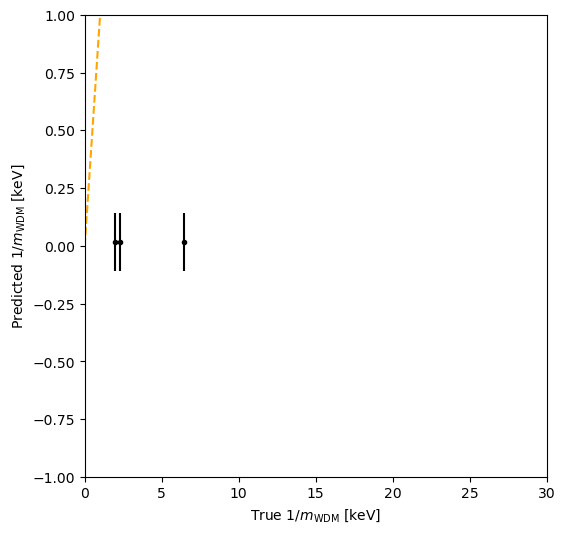

In [13]:
# Plotting results (for WDM model).

fig, ax = plt.subplots(figsize=(6,6))
ax.set_box_aspect(1)
ax.set_xlim(0,30)
ax.set_ylim(-1,1)

ax.plot([0,30],[0,30],'k--', color='orange')
ax.errorbar(1/graph_dict["true"], 1/graph_dict["pred"], yerr=graph_dict["err"]/(graph_dict["pred"]**2), fmt='k.')

ax.set(xlabel="True "+"$1/m_\mathrm{WDM}$"+" [keV]")
ax.set(ylabel="Predicted "+"$1/m_\mathrm{WDM}$"+" [keV]")

plt.show()